#Considerações Iniciais


O estudo feito neste arquivo é para explorar um pouco das funcionalidades do algoritmo de DecisionTree. O dataset utilizado pode ser encontrado no link: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset.
Para quaisquer comentários não hesite em me escrever! 

In [ ]:
#Importação das bibliotecas utilizadas

from google.colab import files #Eu realizei upload do arquivo baixado do link.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import patsy as pt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [ ]:
#Carregando o arquivo diretamente no google collab
uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


#1. Overview e Tratamento

## 1.1 Primeira visão sobre o conjunto

In [ ]:
df_stroke = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col=0)

In [ ]:
df_stroke.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   
31112    Male  80.0             0              1          Yes        Private   
60182  Female  49.0             0              0          Yes        Private   
1665   Female  79.0             1              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1  
31112          Rural             105.92  32.5     never smoked       1  
60182          Urban             171.23  34.4           smokes       1  
1665           Rural             174.12  24.0     never smoked       1

Vemos, pelo head, que aparentemente os valores foram bem encaixados e o df está bem formatado. Agora serão analisadas algumas questões estatísticas para verificarmos a qualidade dos dados

In [ ]:
df_stroke.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [ ]:
df_stroke.describe()

age  hypertension  heart_disease  avg_glucose_level  \
count  5110.000000   5110.000000    5110.000000        5110.000000   
mean     43.226614      0.097456       0.054012         106.147677   
std      22.612647      0.296607       0.226063          45.283560   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.245000   
50%      45.000000      0.000000       0.000000          91.885000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

               bmi       stroke  
count  4909.000000  5110.000000  
mean     28.893237     0.048728  
std       7.854067     0.215320  
min      10.300000     0.000000  
25%      23.500000     0.000000  
50%      28.100000     0.000000  
75%      33.100000     0.000000  
max      97.600000     1.000000

In [ ]:
df_stroke.isna().sum()


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
df_stroke.count()

gender               5110
age                  5110
hypertension         5110
heart_disease        5110
ever_married         5110
work_type            5110
Residence_type       5110
avg_glucose_level    5110
bmi                  4909
smoking_status       5110
stroke               5110
dtype: int64

In [ ]:
df_stroke = df_stroke.dropna(axis=0)

As variáveis numéricas estão em uma ordem de grandeza parecida, portanto, não há necessidade de normalização. Além disso, visto a quantidade ínfima de nulos achei interessante descartar as informações perante o total. Uma outra abordagem poderia ser inserir a média dos valores de bmi nos valores nulos de bmi. Todavia, preferi optar por descartar linhas com dados faltantes nesta análise

##1.2 Separando variáveis

In [ ]:
category = ['gender','ever_married','work_type','Residence_type','smoking_status',
            'heart_disease','hypertension']
for i in category:
  df_stroke[i] = df_stroke[i].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
xCat = df_stroke.select_dtypes(include='category')
xCat.head()

gender hypertension heart_disease ever_married      work_type  \
id                                                                     
9046     Male            0             1          Yes        Private   
31112    Male            0             1          Yes        Private   
60182  Female            0             0          Yes        Private   
1665   Female            1             0          Yes  Self-employed   
56669    Male            0             0          Yes        Private   

      Residence_type   smoking_status  
id                                     
9046           Urban  formerly smoked  
31112          Rural     never smoked  
60182          Urban           smokes  
1665           Rural     never smoked  
56669          Urban  formerly smoked

In [ ]:
xNum = df_stroke.select_dtypes(include='number')
xNum.drop(columns=['stroke'],inplace=True)
xNum


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


age  avg_glucose_level   bmi
id                                  
9046   67.0             228.69  36.6
31112  80.0             105.92  32.5
60182  49.0             171.23  34.4
1665   79.0             174.12  24.0
56669  81.0             186.21  29.0
...     ...                ...   ...
14180  13.0             103.08  18.6
44873  81.0             125.20  40.0
19723  35.0              82.99  30.6
37544  51.0             166.29  25.6
44679  44.0              85.28  26.2

[4909 rows x 3 columns]

In [ ]:
y = df_stroke['stroke']
y.head()

id
9046     1
31112    1
60182    1
1665     1
56669    1
Name: stroke, dtype: int64

##1.3 Distribuição das variáveis

### Variaveis categóricas

In [ ]:
xCat.head(1)

gender hypertension heart_disease ever_married work_type Residence_type  \
id                                                                             
9046   Male            0             1          Yes   Private          Urban   

       smoking_status  
id                     
9046  formerly smoked

In [ ]:
xCat['gender'].unique(), xCat['ever_married'].unique(), xCat['work_type'].unique(), xCat['Residence_type'].unique(), xCat['smoking_status'].unique(), xCat['heart_disease'].unique(), xCat['hypertension'].unique() 

(['Male', 'Female', 'Other']
 Categories (3, object): ['Female', 'Male', 'Other'], ['Yes', 'No']
 Categories (2, object): ['No', 'Yes'], ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
 Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'], ['Urban', 'Rural']
 Categories (2, object): ['Rural', 'Urban'], ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
 Categories (4, object): ['Unknown', 'formerly smoked', 'never smoked', 'smokes'], [1, 0]
 Categories (2, int64): [0, 1], [0, 1]
 Categories (2, int64): [0, 1])

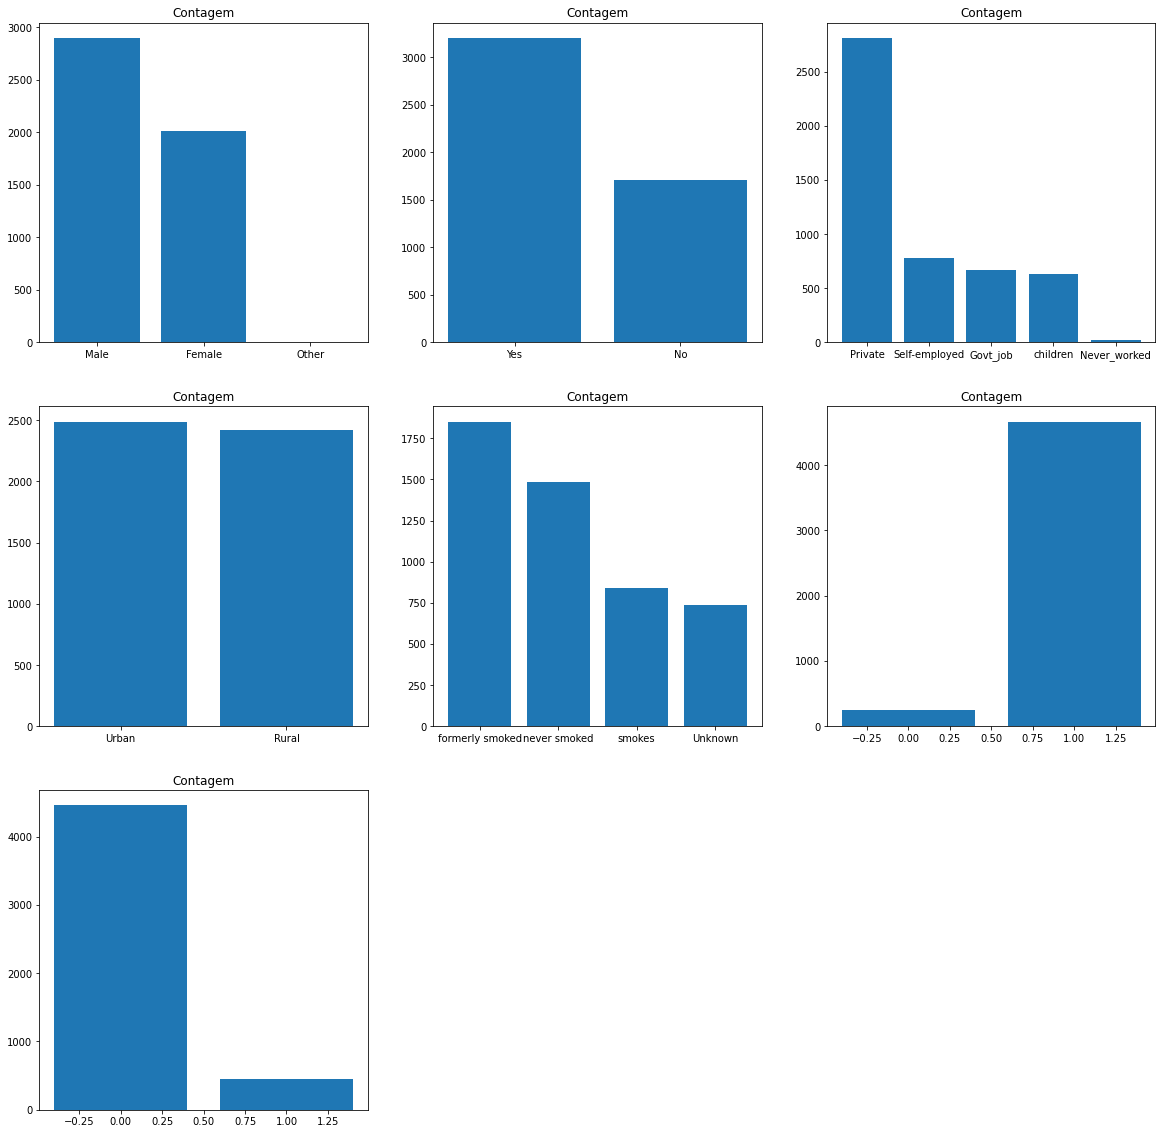

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)

ax1.bar(xCat['gender'].unique(),xCat['gender'].value_counts())
ax1.set_title('Contagem')

ax2.bar(xCat['ever_married'].unique(),xCat['ever_married'].value_counts())
ax2.set_title('Contagem')

ax3.bar(xCat['work_type'].unique(),xCat['work_type'].value_counts())
ax3.set_title('Contagem')


ax4.bar(xCat['Residence_type'].unique(),xCat['Residence_type'].value_counts())
ax4.set_title('Contagem')

ax5.bar(xCat['smoking_status'].unique(),xCat['smoking_status'].value_counts())
ax5.set_title('Contagem')

ax6.bar(xCat['heart_disease'].unique(),xCat['heart_disease'].value_counts())
ax6.set_title('Contagem')

ax7.bar(xCat['hypertension'].unique(),xCat['hypertension'].value_counts())
ax7.set_title('Contagem')

plt.show()


Gráfico simples, sem muitos detalhes visuais para facilitar a visualização rápida. O gráfico acima tem como objetivo apenas ilustrar a quantidade dos valores distintos para cada cenário. Vemos que o tipo de residência está bem distribuído, mas optei por continuar com essa variável dado o tamanho da base

###Variáveis numéricas

In [ ]:
xNum.head(1)

age  avg_glucose_level   bmi
id                                 
9046  67.0             228.69  36.6

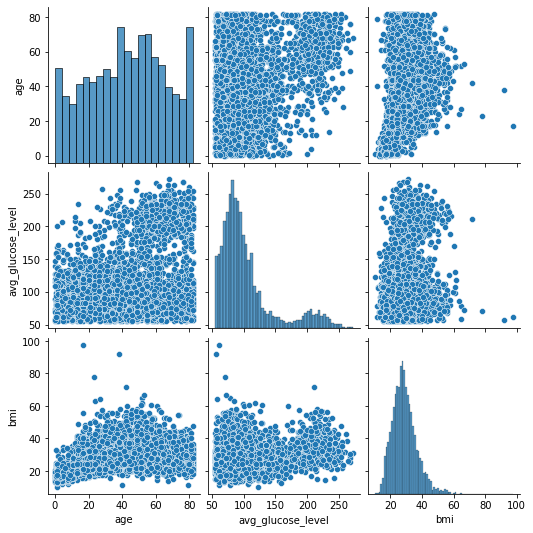

In [ ]:
sns.pairplot(xNum)

O gráfico de correlação não está bem definido. Houve até mesmo a tentativa, a qual não está registrada aqui, de elaborar os modelos sem uma das variáveis acima. Em todos os cenários os resultados foram inferiores aos resultados com todas as variáveis.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

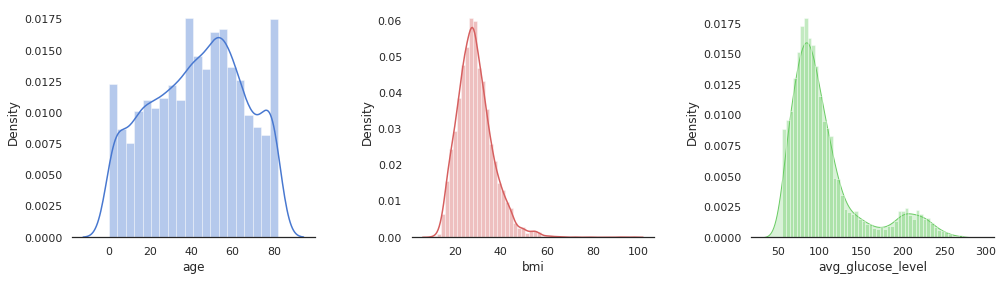

In [ ]:
sns.set(style="white", palette="muted", color_codes=True)
rs = np.random.RandomState(10)

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(16,4))
sns.despine(left=True)

sns.distplot(xNum['age'], hist=True, color="b", ax=axes[0])

# Plot a kernel density estimate and rug plot
sns.distplot(xNum['bmi'], hist=True, color="r", ax=axes[1])

# Plot a filled kernel density estimate
sns.distplot(xNum['avg_glucose_level'], hist=True, color="g", kde_kws={"shade": True}, ax=axes[2])


plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

#2. Revisão e Unificação

##Variável Contínua

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d5f58f9d0>,
      dtype=object)

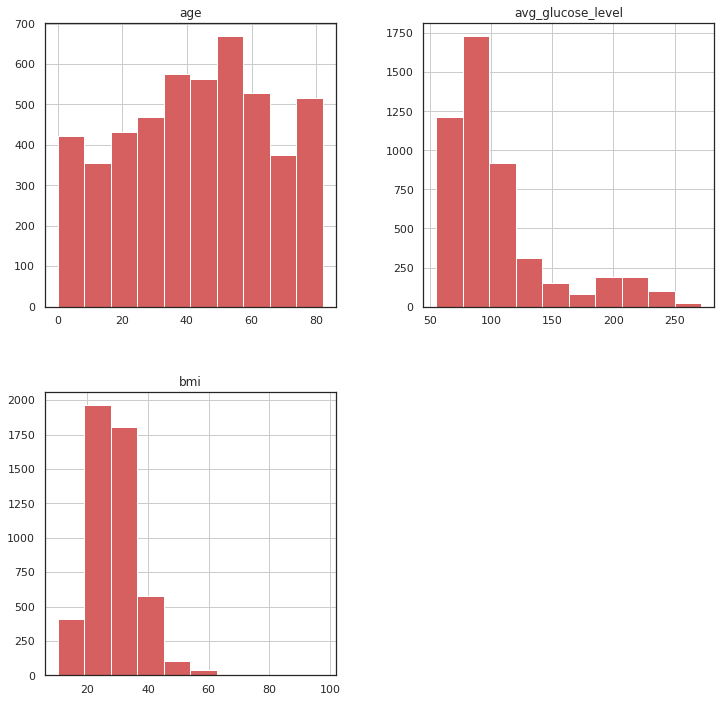

In [ ]:
xNum.hist(figsize=(12,12),color='r')

##Variável Categórica

In [ ]:
xCatD = pd.get_dummies(xCat)
xCatD.head()

gender_Female  gender_Male  gender_Other  hypertension_0  \
id                                                                
9046               0            1             0               1   
31112              0            1             0               1   
60182              1            0             0               1   
1665               1            0             0               0   
56669              0            1             0               1   

       hypertension_1  heart_disease_0  heart_disease_1  ever_married_No  \
id                                                                         
9046                0                0                1                0   
31112               0                0                1                0   
60182               0                1                0                0   
1665                1                1                0                0   
56669               0                1                0                0   

       ever_married_Yes  work_type_Govt_job  work_type_Never_worked  \
id                                                                    
9046                  1                   0                       0   
31112                 1                   0                       0   
60182                 1                   0                       0   
1665                  1                   0                       0   
56669                 1                   0                       0   

       work_type_Private  work_type_Self-employed  work_type_children  \
id                                                                      
9046                   1                        0                   0   
31112                  1                        0                   0   
60182                  1                        0                   0   
1665                   0                        1                   0   
56669                  1                        0                   0   

       Residence_type_Rural  Residence_type_Urban  smoking_status_Unknown  \
id                                                                          
9046                      0                     1                       0   
31112                     1                     0                       0   
60182                     0                     1                       0   
1665                      1                     0                       0   
56669                     0                     1                       0   

       smoking_status_formerly smoked  smoking_status_never smoked  \
id                                                                   
9046                                1                            0   
31112                               0                            1   
60182                               0                            0   
1665                                0                            1   
56669                               1                            0   

       smoking_status_smokes  
id                            
9046                       0  
31112                      0  
60182                      1  
1665                       0  
56669                      0

## Unificando

In [ ]:
dfCat = pd.concat([y,xCatD], axis=1)
dfNorm = pd.concat([y, xNum], axis=1)
dfFinal = pd.concat([dfNorm, dfCat.drop(columns='stroke')], axis=1)
dfFinal

stroke   age  avg_glucose_level   bmi  gender_Female  gender_Male  \
id                                                                         
9046        1  67.0             228.69  36.6              0            1   
31112       1  80.0             105.92  32.5              0            1   
60182       1  49.0             171.23  34.4              1            0   
1665        1  79.0             174.12  24.0              1            0   
56669       1  81.0             186.21  29.0              0            1   
...       ...   ...                ...   ...            ...          ...   
14180       0  13.0             103.08  18.6              1            0   
44873       0  81.0             125.20  40.0              1            0   
19723       0  35.0              82.99  30.6              1            0   
37544       0  51.0             166.29  25.6              0            1   
44679       0  44.0              85.28  26.2              1            0   

       gender_Other  hypertension_0  hypertension_1  heart_disease_0  ...  \
id                                                                    ...   
9046              0               1               0                0  ...   
31112             0               1               0                0  ...   
60182             0               1               0                1  ...   
1665              0               0               1                1  ...   
56669             0               1               0                1  ...   
...             ...             ...             ...              ...  ...   
14180             0               1               0                1  ...   
44873             0               1               0                1  ...   
19723             0               1               0                1  ...   
37544             0               1               0                1  ...   
44679             0               1               0                1  ...   

       work_type_Never_worked  work_type_Private  work_type_Self-employed  \
id                                                                          
9046                        0                  1                        0   
31112                       0                  1                        0   
60182                       0                  1                        0   
1665                        0                  0                        1   
56669                       0                  1                        0   
...                       ...                ...                      ...   
14180                       0                  0                        0   
44873                       0                  0                        1   
19723                       0                  0                        1   
37544                       0                  1                        0   
44679                       0                  0                        0   

       work_type_children  Residence_type_Rural  Residence_type_Urban  \
id                                                                      
9046                    0                     0                     1   
31112                   0                     1                     0   
60182                   0                     0                     1   
1665                    0                     1                     0   
56669                   0                     0                     1   
...                   ...                   ...                   ...   
14180                   1                     1                     0   
44873                   0                     0                     1   
19723                   0                     1                     0   
37544                   0                     1                     0   
44679                   0                     0                     1   

       smoking_status_Unknown  smoking_status_formerly smoked  \

#3. Treinando Modelo

In [ ]:
X = dfFinal.drop(columns=['stroke'])
y = dfFinal[['stroke']] #Assim gera um DF. Bem util


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=7)

In [ ]:
clf = DecisionTreeClassifier(criterion='entropy') #Usando entropia como critério.


In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


#4. Parâmetros de Avaliação

In [ ]:
from sklearn.metrics import accuracy_score
print (f"Acurácia: {accuracy_score(y_test,y_pred)}")

print (f"Curva Roc: {roc_auc_score(y, clf.predict_proba(X)[:, 1])}")


Acurácia: 0.9226069246435845
Curva Roc: 0.8644304184057823


Resultados não satisfatórios, tentar utilizar uma RandomForest da próxima vez para otimizar os hiperparâmetros e ver se há um ganho.

#5. Visualizando a **árvore** em detalhes

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['no','yes'],
                           filled=True, rounded=True,
                           special_characters=True)

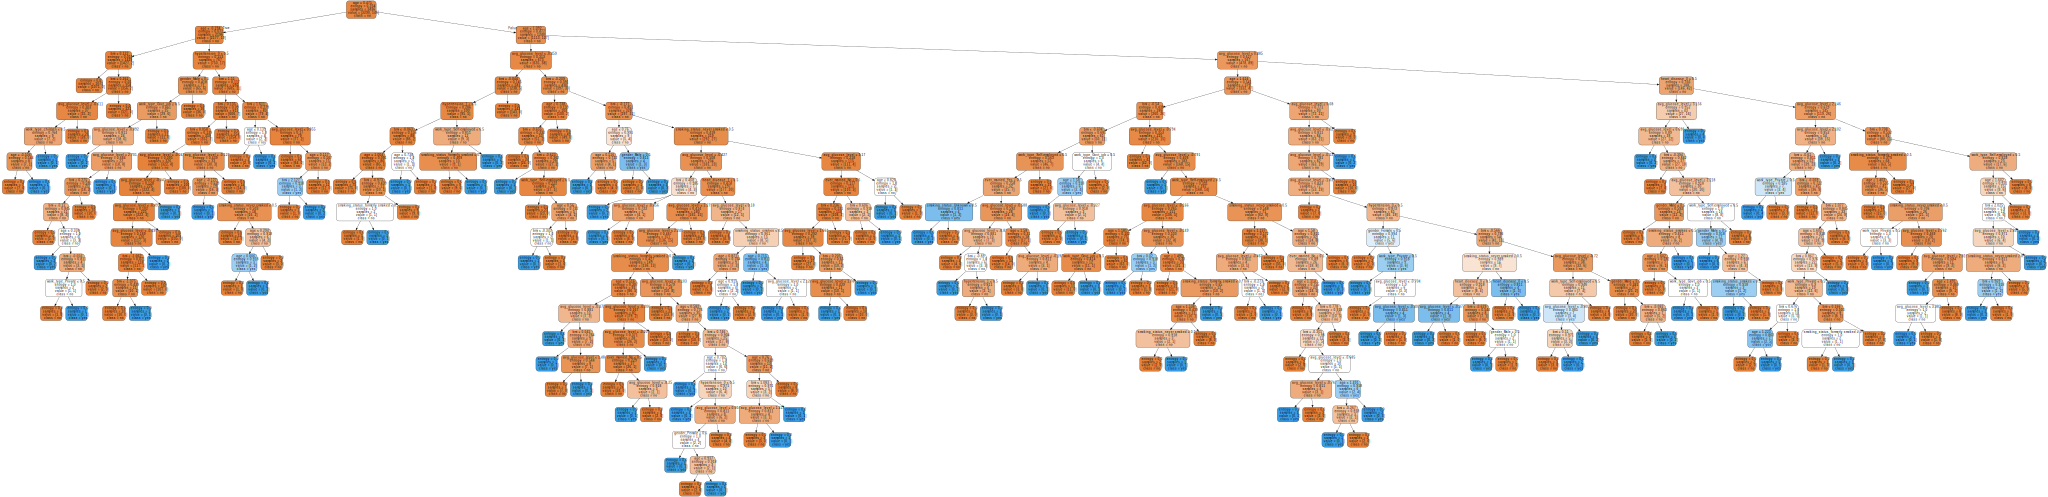

In [ ]:
graph = graphviz.Source(dot_data)
graph

In [ ]:
!pip install dtreeviz 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-py3-none-any.whl size=68151 sha256=e8b03895e57b8731e7441928b4be13149b367adc33c93a999bde24802f39b326
  Stored in directory: /root/.cache/pip/wheels/bf/ba/9f/87c689d8d3c2916793f2dccc57d3dc3b283e0ccf8cb4ca4cad
Successfully built dtreeviz


In [ ]:
from dtreeviz.trees import *
viz = dtreeviz(clf,
               X_train.values,
               y_train['stroke'].values,
               target_name='stroke',
               feature_names=X_train.columns,
               class_names=['no','yes'],
               histtype='barstacked')
viz

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
